# Neural & Behavioral Modeling - Week 10 (Exercises)
by 李彥廷 (b08207008@ntu.edu.tw)

In [1]:
# Upgrade PyTorch if necessary:
# ! conda install -y pytorch-cpu torchvision-cpu -c pytorch

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

In [2]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
if(t.cuda.is_available()):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
else:
    print('No GPU')

PyTorch version: 1.13.0
No GPU


## 1 Tuning the performance of a neural net (8 points)

### 1.1 Problem
In the section 4.1 of model_10_examples.ipynb, the neural network implemented in NumPy with two hidden layers could reach 90% classification accuracy on the MNIST training data only within 3 learning epochs:

<pre>
model=MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100], output_size=10,
                          weight_init_std=weight_init_std, use_batchnorm=True, use_dropout=True)
</pre>

However, in the section 4.2, a similar network implemented in PyTorch did not reached 90% clasification accuracy model on the MNIST training data: 

<pre>
model = t.nn.Sequential(
    t.nn.Linear(D_in, H),
    #t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    #t.nn.Linear(H, H),
    #t.nn.BatchNorm1d(H),
    #ct.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    t.nn.Linear(H, D_out),
    t.nn.Softmax()
)
</pre>

Your goal is to do whatever you can to help the PyTorch net reach 90% classification accuracy on the MNIST training data within 50 or less epochs.

### 1.2 Tips

First try to eliminate the differences between the NumPy net and the PyTorch net:

(1) The PyTorch version did not use 50% Dropout.

(2) The PyTorch used Adam with a learning rate of 1e-4 as an optimizer instead of SGD with a learning rate of 1e-2.

(3) The PyTroch version did not use shuffled batch (100 samples) in each training epoch.


(4)If removal of the above differences does not help, look for other differences or do whatever you can to accelerate learning of the PyTorch net.

<b>(5) Do not waste your time on checking out training results after 50 epochs! They have nothing to do with your goal here.</b>

### 1.3 Your codes and discussions

#### 1.3.1 The MNIST dataset

In [4]:
# Download the dataset:
import urllib.request
urllib.request.urlretrieve('https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz','mnist.pkl.gz')

('mnist.pkl.gz', <http.client.HTTPMessage at 0x7fc6391b3610>)

/var/folders/kd/bdrqt3tj351gf36v20dm1wqr0000gn/T/ipykernel_98818/2630220359.py:4: DeprecationWarning: invalid escape sequence '\>'
  train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
/var/folders/kd/bdrqt3tj351gf36v20dm1wqr0000gn/T/ipykernel_98818/2630220359.py:4: DeprecationWarning: invalid escape sequence '\?'
  train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')


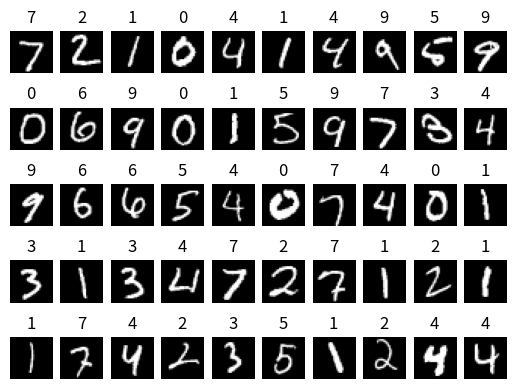

In [19]:
# Load the dataset:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
f.close()
x_train,y_train=train_set[0],train_set[1]
x_valid,y_valid=valid_set[0],valid_set[1]
x_test,y_test=test_set[0],test_set[1]

# Examine the dataset:
# print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
# print(np.min(x_train),np.max(x_train),np.min(y_train),np.max(y_train))
for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(y_test[i]));
    axis('off')
    
# Transform NumPy arrays to PyTorch tensors:
use_cuda=t.cuda.is_available()

X_train=t.from_numpy(x_train)
Y_train=t.from_numpy(y_train)
X_valid=t.from_numpy(x_valid)
Y_valid=t.from_numpy(y_valid)
X_test=t.from_numpy(x_test)
Y_test=t.from_numpy(y_test)

if(use_cuda):
    X_train=X_train.cuda()
    Y_train=Y_train.cuda()
    X_valid=X_valid.cuda()
    Y_valid=Y_valid.cuda()
    X_test=X_test.cuda()
    Y_test=Y_test.cuda()

#### 1.3.2 Your systematic explorations

改了以下東西
1. 20% dropout
2. Adam optimizer with 0.001 learning rate
3. batch size = 500
4. shuffled batch in each training epoch.

In [20]:
# Here is the PyTorch net:

D_in,H,D_out=784,100,10

# Training the network:
model = t.nn.Sequential(
    t.nn.Linear(D_in, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Dropout(p=0.2),
    t.nn.Linear(H, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Dropout(p=0.2),
    t.nn.Linear(H, D_out),
    t.nn.Softmax(dim=1)
)

loss_fn = t.nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = t.optim.Adam(model.parameters(), lr=learning_rate) #https://pytorch.org/docs/stable/optim.html

if(use_cuda):
    model=model.cuda()
    loss_fn=loss_fn.cuda()


# Specify batch size
batch_size = 500
n_batch = int(len(X_train)/batch_size)
# Split the training data
X_train_batches = X_train.reshape(n_batch, batch_size, -1) 
Y_train_batches = Y_train.reshape(n_batch, batch_size)

for i in range(51):

    # shuffle batches
    randIndex = t.randperm(n_batch)
    X_train_batches = X_train_batches[randIndex,:,:]
    Y_train_batches = Y_train_batches[randIndex,:]

    for batch in range(len(X_train_batches)):
        # Forward pass:
        Y_pred = model(X_train_batches[batch])
        loss = loss_fn(Y_pred, Y_train_batches[batch])
        
        # Zero the gradients before running the backward pass.
        model.zero_grad()

        # Backward pass:
        loss.backward()

        # Update the weights using gradient descent:
        optimizer.step()
        
    # Check training accuracy:
    if i % 10 == 0:
        Y_pred = model(X_train) # Y_pred.shape=[50000,10]
        Y_pred = t.max(Y_pred,1)[1] # Y_pred.shape=[50000]
        print('epoch ',i,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])

tensor([[0.1679, 0.0704, 0.0805,  ..., 0.0547, 0.1431, 0.1114],
        [0.0747, 0.0624, 0.3019,  ..., 0.1041, 0.0963, 0.0969],
        [0.0821, 0.1937, 0.0961,  ..., 0.1361, 0.0783, 0.0892],
        ...,
        [0.0725, 0.1191, 0.0977,  ..., 0.1299, 0.0798, 0.0384],
        [0.1045, 0.0721, 0.0970,  ..., 0.2006, 0.0693, 0.0966],
        [0.1089, 0.1222, 0.0812,  ..., 0.0789, 0.1757, 0.0989]],
       grad_fn=<SoftmaxBackward0>)
epoch  0 : 0.08586
tensor([[0.0892, 0.0778, 0.2650,  ..., 0.0731, 0.1460, 0.0548],
        [0.1024, 0.1256, 0.0754,  ..., 0.1023, 0.0717, 0.1825],
        [0.1092, 0.0970, 0.0715,  ..., 0.2314, 0.0888, 0.0474],
        ...,
        [0.1331, 0.0821, 0.0752,  ..., 0.1432, 0.1301, 0.0604],
        [0.1663, 0.0597, 0.0938,  ..., 0.0932, 0.1176, 0.0882],
        [0.1066, 0.1224, 0.0813,  ..., 0.1125, 0.0686, 0.0632]],
       grad_fn=<SoftmaxBackward0>)
tensor([[0.1938, 0.0503, 0.0772,  ..., 0.1081, 0.1169, 0.0747],
        [0.1855, 0.0590, 0.0979,  ..., 0.0498, 0.25

tensor([[0.0591, 0.2109, 0.1441,  ..., 0.1260, 0.0617, 0.0550],
        [0.0670, 0.1333, 0.1008,  ..., 0.0949, 0.1042, 0.0862],
        [0.1005, 0.0709, 0.0820,  ..., 0.2688, 0.0457, 0.0946],
        ...,
        [0.0778, 0.0360, 0.1250,  ..., 0.0601, 0.0783, 0.0894],
        [0.0936, 0.1278, 0.1321,  ..., 0.1183, 0.0742, 0.0521],
        [0.0679, 0.1246, 0.1536,  ..., 0.1125, 0.0931, 0.0734]],
       grad_fn=<SoftmaxBackward0>)
tensor([[0.1207, 0.1857, 0.0876,  ..., 0.1863, 0.0293, 0.1357],
        [0.1978, 0.0470, 0.0762,  ..., 0.0801, 0.1119, 0.0823],
        [0.1154, 0.0844, 0.0681,  ..., 0.1810, 0.0936, 0.0727],
        ...,
        [0.2105, 0.0760, 0.0979,  ..., 0.1249, 0.0631, 0.1090],
        [0.0607, 0.1408, 0.1224,  ..., 0.2160, 0.0781, 0.0937],
        [0.0908, 0.1797, 0.0771,  ..., 0.0807, 0.1003, 0.1030]],
       grad_fn=<SoftmaxBackward0>)
tensor([[0.0902, 0.0649, 0.2281,  ..., 0.1748, 0.0654, 0.0747],
        [0.0756, 0.1246, 0.0982,  ..., 0.0790, 0.0905, 0.0887],
      

In [21]:
# validation set
Y_pred = model(X_valid) 
Y_pred = t.max(Y_pred,1)[1] 
print('validation set accuracy:',(Y_pred==Y_valid).sum().item()/Y_valid.shape[0])

validation set accuracy: 0.0896
